In [1]:
# ================================================================
# ANN 
# ================================================================

import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedKFold, LeaveOneOut
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, balanced_accuracy_score, f1_score
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE, RandomOverSampler
from imblearn.pipeline import Pipeline
import statsmodels.stats.proportion as smp
from itertools import product
import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=ConvergenceWarning)

# -----------------------
# 0) Ayarlar
# -----------------------
FILE_PATH = "ML_Analysis_V3.xlsx"   # <-- kendi yolun
TARGETS = ["Cervical Lordosis Risk","Kyphosis Risk","Lumbar Lordosis Risk","Scoliosis Risk"]
RUN_LOSO = True                     # hızlı istersen False yap
TUNING_SCORING = "balanced_accuracy"  # alternatif: "f1_macro"

# -----------------------
# 1) Veri seti
# -----------------------
df = pd.read_excel(FILE_PATH, sheet_name="Sheet1")
feature_cols = [c for c in df.columns if c not in TARGETS]

# -----------------------
# 2) Yardımcılar
# -----------------------
def make_adaptive_sampler(y_train):
    """ Minority sayısına göre SMOTE(k) ya da ROS seç. """
    counts = y_train.value_counts().to_dict()
    minority_n = min(counts.get(0, 0), counts.get(1, 0))
    if minority_n >= 3:
        k = max(1, min(5, minority_n - 1))
        return SMOTE(k_neighbors=k, random_state=42)
    else:
        return RandomOverSampler(random_state=42)

def get_stratified_cv(y, desired_splits):
    """ StratifiedKFold kat sayısını min sınıfa göre adaptif seç. """
    minority_n = y.value_counts().min()
    n_splits = max(2, min(desired_splits, int(minority_n))) if int(minority_n) > 1 else 2
    return StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42), n_splits

def fit_predict_one_fold_ann(X_train, y_train, X_test, ann_params):
    """ Tek fold eğitimi: StandardScaler -> Sampler -> MLPClassifier """
    sampler = make_adaptive_sampler(y_train)
    pipe = Pipeline([
        ('scaler', StandardScaler()),
        ('sampler', sampler),
        ('ann', MLPClassifier(**ann_params))
    ])
    pipe.fit(X_train, y_train)
    return pipe.predict(X_test)

# -----------------------
# 3) Global tuning (hızlı)
# -----------------------
def global_tune_ann(X, y, desired_splits=5, scoring="balanced_accuracy"):
    skf, used_splits = get_stratified_cv(y, desired_splits)

    # Makul, küçük bir grid: küçük veri + erken durdurma
    grid = {
        "hidden_layer_sizes": [(8,), (16,), (32,), (16,8), (32,16)],
        "activation": ["relu", "tanh"],
        "alpha": [0.0001, 0.001, 0.01],           # L2
        "learning_rate": ["adaptive"],            # step-based
        "learning_rate_init": [0.001, 0.01],
        "solver": ["adam"],
        "max_iter": [1000],
        "early_stopping": [True],
        "n_iter_no_change": [20],
        "random_state": [42]
    }

    keys = list(grid.keys()); vals = [grid[k] for k in keys]
    best_score, best_params = -np.inf, None

    for combo in product(*vals):
        p = dict(zip(keys, combo))
        fold_scores = []
        for tr, va in skf.split(X, y):
            X_tr, X_va = X.iloc[tr], X.iloc[va]
            y_tr, y_va = y.iloc[tr], y.iloc[va]
            sampler = make_adaptive_sampler(y_tr)
            pipe = Pipeline([
                ('scaler', StandardScaler()),
                ('sampler', sampler),
                ('ann', MLPClassifier(**p))
            ])
            pipe.fit(X_tr, y_tr)
            pred = pipe.predict(X_va)
            s = balanced_accuracy_score(y_va, pred) if scoring=="balanced_accuracy" \
                else f1_score(y_va, pred, average="macro")
            fold_scores.append(s)
        m = np.mean(fold_scores)
        if m > best_score:
            best_score, best_params = m, p

    return best_params, best_score, used_splits

# -----------------------
# 4) Değerlendirme
# -----------------------
def evaluate_scheme_ann(X, y, splitter, scheme_name, ann_params):
    splits = splitter.split(X, y) if isinstance(splitter, StratifiedKFold) else splitter.split(X)
    y_true, y_pred = [], []
    for tr, te in splits:
        X_tr, X_te = X.iloc[tr], X.iloc[te]
        y_tr, y_te = y.iloc[tr], y.iloc[te]
        pred = fit_predict_one_fold_ann(X_tr, y_tr, X_te, ann_params)
        y_true.extend(y_te); y_pred.extend(pred)

    rep = classification_report(y_true, y_pred, output_dict=True, zero_division=0)
    cm  = confusion_matrix(y_true, y_pred, labels=[0,1])
    tn, fp, fn, tp = cm.ravel()
    acc = accuracy_score(y_true, y_pred)
    n = len(y_true); k = int((np.array(y_true) == np.array(y_pred)).sum())
    ci_lo, ci_hi = smp.proportion_confint(k, n, alpha=0.05, method='wilson')

    return {
        "Scheme": scheme_name,
        "Accuracy": acc,
        "95% CI Low": ci_lo, "95% CI High": ci_hi,
        "Weighted Precision": rep["weighted avg"]["precision"],
        "Weighted Recall": rep["weighted avg"]["recall"],
        "Weighted F1": rep["weighted avg"]["f1-score"],
        "Support": int(cm.sum()), "TN": int(tn), "FP": int(fp), "FN": int(fn), "TP": int(tp)
    }

# -----------------------
# 5) Çalıştır
# -----------------------
all_rows, tuning_rows = [], []

for target in TARGETS:
    print(f"\n=== ANN Tuning & Evaluation for: {target} ===")
    X = df[feature_cols].copy(); y = df[target].copy()

    best_params, best_cv, used_splits = global_tune_ann(X, y, desired_splits=5, scoring=TUNING_SCORING)
    print(f"Best params (Stratified {used_splits}-Fold): {best_params} | Mean CV ({TUNING_SCORING}): {round(best_cv,3)}")
    tuning_rows.append({"Target": target, "CV (tuning)": f"Stratified {used_splits}-Fold",
                        "Best Params": best_params, f"Mean CV ({TUNING_SCORING})": round(best_cv,3)})

    if RUN_LOSO:
        row_loso = evaluate_scheme_ann(X, y, LeaveOneOut(), "LOSO", best_params)
        all_rows.append({"Target": target, **row_loso})

    cv5, used5   = get_stratified_cv(y, 5)
    cv10, used10 = get_stratified_cv(y, 10)

    row_s5  = evaluate_scheme_ann(X, y, cv5,  f"Stratified {used5}-Fold",  best_params)
    row_s10 = evaluate_scheme_ann(X, y, cv10, f"Stratified {used10}-Fold", best_params)
    all_rows += [{"Target": target, **row_s5}, {"Target": target, **row_s10}]

summary_ann = pd.DataFrame(all_rows)
tuning_summary = pd.DataFrame(tuning_rows)

print("\n=== ANN – Master Table (LOSO + adaptive 5/10-Fold) ===")
print(summary_ann)
print("\n=== ANN – Tuning Summary ===")
print(tuning_summary)

# CSV istersen:
# summary_ann.to_csv("ANN_Scaled_AdaptiveOversampling_AdaptiveCV_AllTargets.csv", index=False)
# tuning_summary.to_csv("ANN_Tuning_Summary.csv", index=False)



=== ANN Tuning & Evaluation for: Cervical Lordosis Risk ===
Best params (Stratified 5-Fold): {'hidden_layer_sizes': (32, 16), 'activation': 'tanh', 'alpha': 0.0001, 'learning_rate': 'adaptive', 'learning_rate_init': 0.01, 'solver': 'adam', 'max_iter': 1000, 'early_stopping': True, 'n_iter_no_change': 20, 'random_state': 42} | Mean CV (balanced_accuracy): 0.765

=== ANN Tuning & Evaluation for: Kyphosis Risk ===
Best params (Stratified 5-Fold): {'hidden_layer_sizes': (32, 16), 'activation': 'tanh', 'alpha': 0.0001, 'learning_rate': 'adaptive', 'learning_rate_init': 0.01, 'solver': 'adam', 'max_iter': 1000, 'early_stopping': True, 'n_iter_no_change': 20, 'random_state': 42} | Mean CV (balanced_accuracy): 0.708

=== ANN Tuning & Evaluation for: Lumbar Lordosis Risk ===
Best params (Stratified 4-Fold): {'hidden_layer_sizes': (8,), 'activation': 'relu', 'alpha': 0.0001, 'learning_rate': 'adaptive', 'learning_rate_init': 0.01, 'solver': 'adam', 'max_iter': 1000, 'early_stopping': True, 'n_i

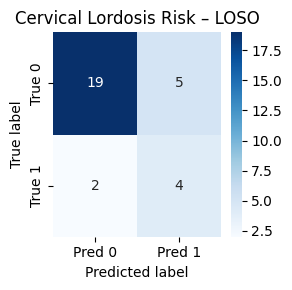

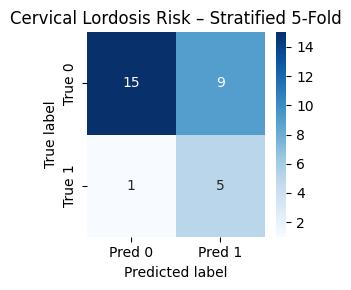

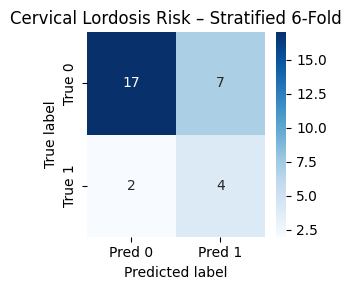

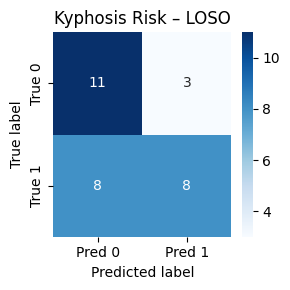

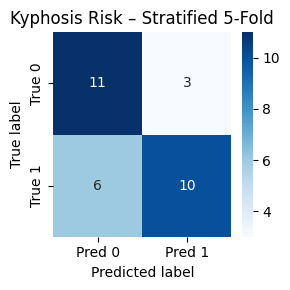

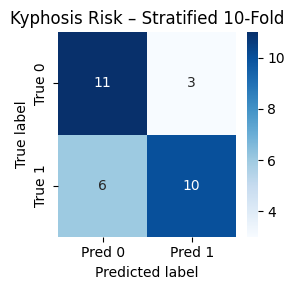

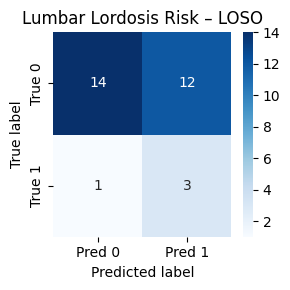

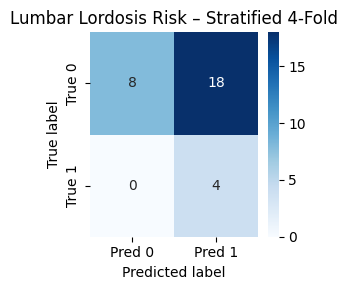

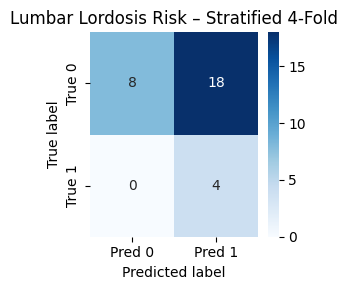

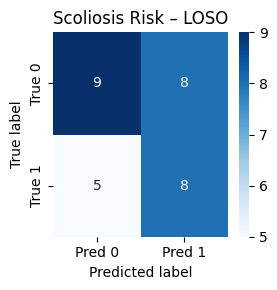

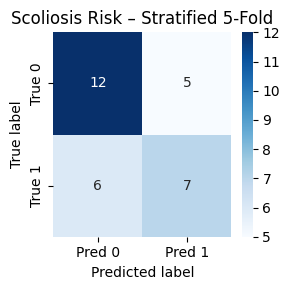

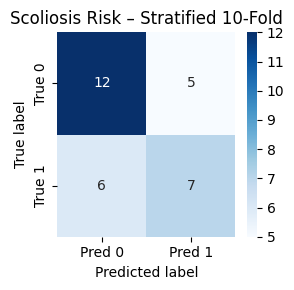

In [2]:
# ================================================================
# 6) Confusion Matrix Heatmaps (Supplementary Figures)
# ================================================================
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

for i, row in summary_ann.iterrows():
    cm = np.array([[row["TN"], row["FP"]],
                   [row["FN"], row["TP"]]])
    plt.figure(figsize=(3,3))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=["Pred 0", "Pred 1"],
                yticklabels=["True 0", "True 1"])
    plt.title(f"{row['Target']} – {row['Scheme']}")
    plt.ylabel("True label")
    plt.xlabel("Predicted label")
    plt.tight_layout()
    plt.show()

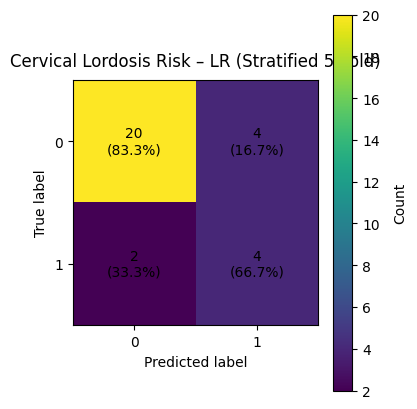

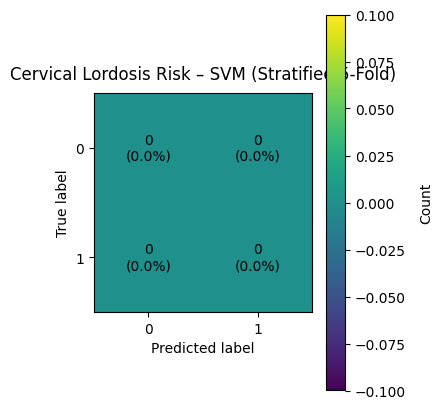

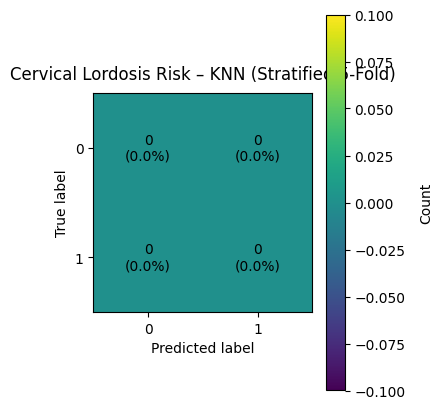

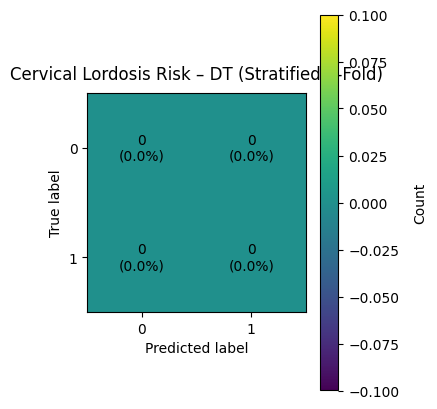

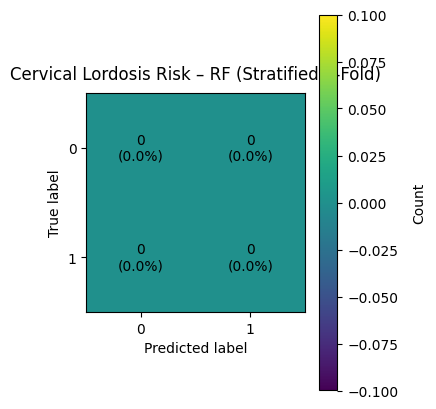

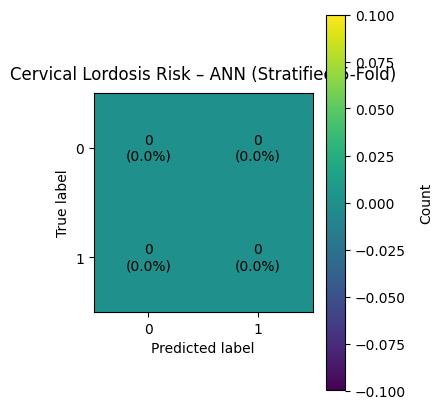

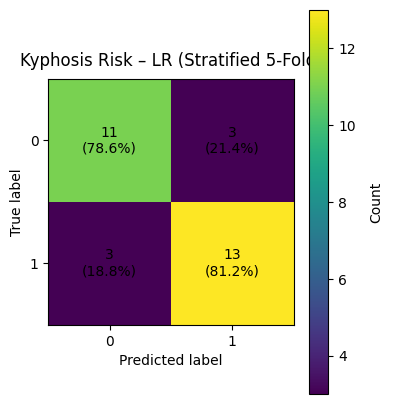

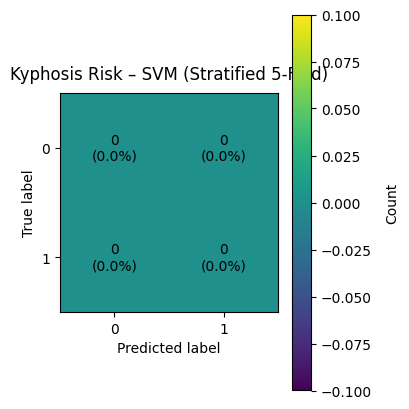

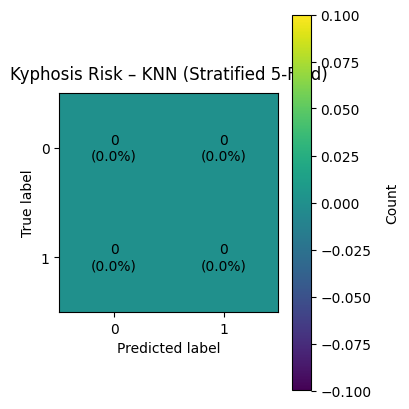

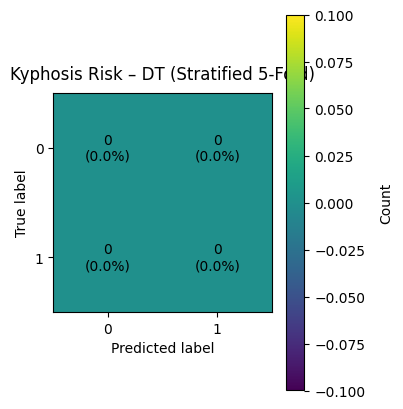

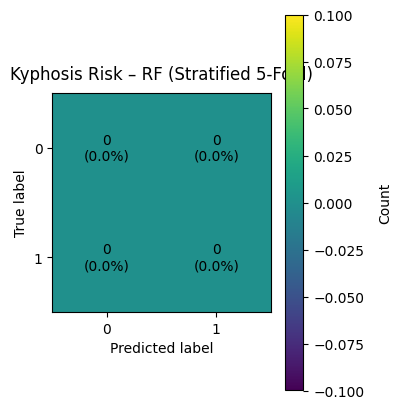

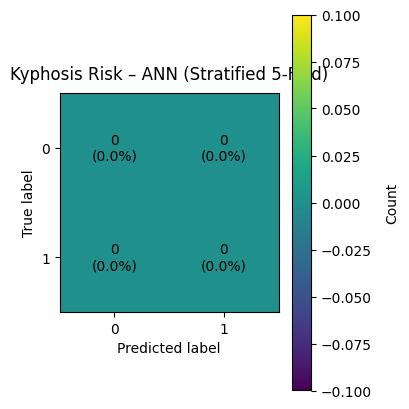

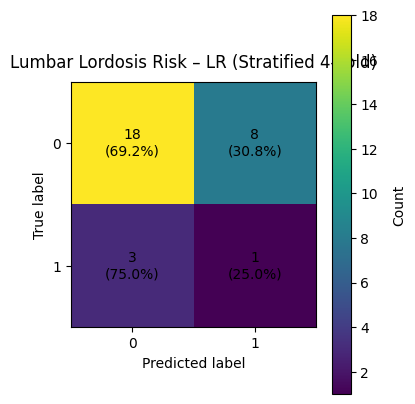

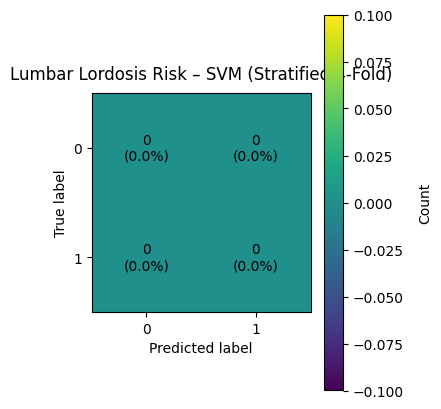

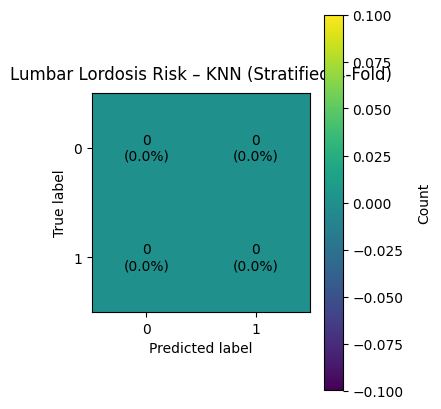

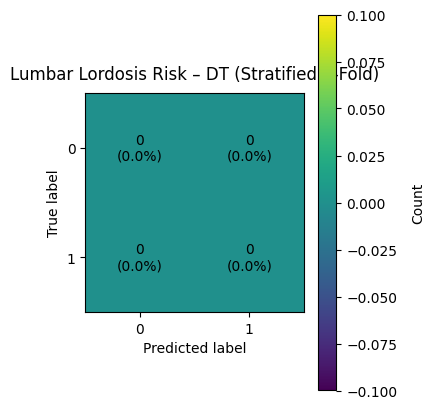

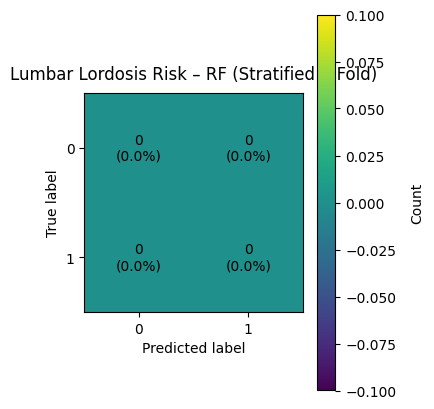

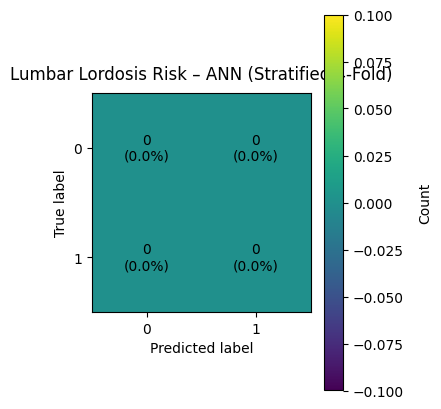

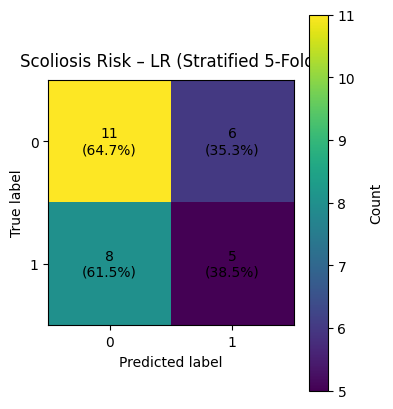

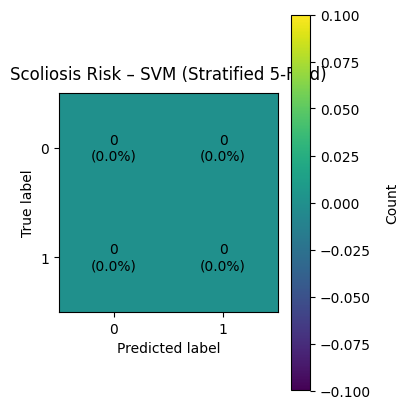

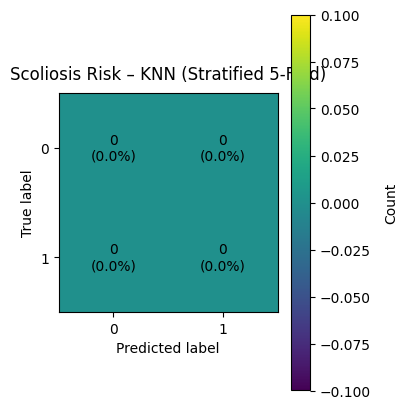

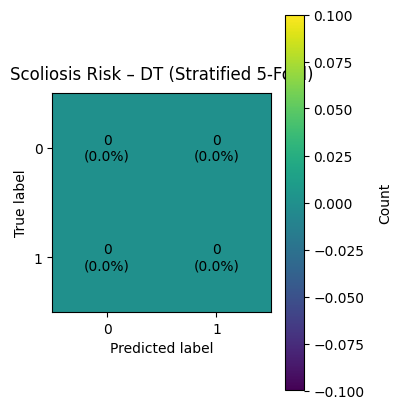

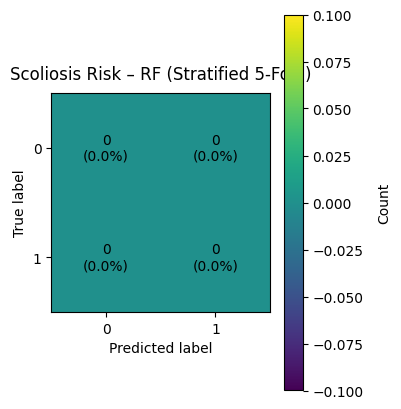

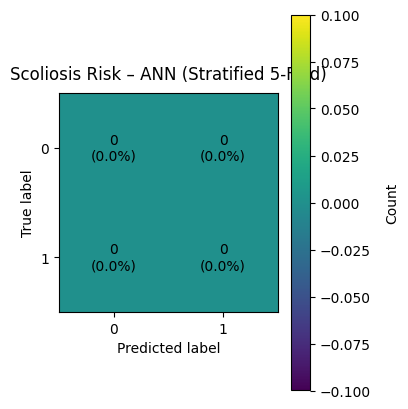

In [3]:
# === Confusion Matrices for ALL targets & algorithms (single scheme per all) ===
# Scheme: Stratified 5-Fold (adaptive to minority count)
# No file saving; figures shown inline. (Optional save dir at the bottom is commented out.)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import StratifiedKFold, LeaveOneOut
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler

from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier

from imblearn.over_sampling import SMOTE, RandomOverSampler
from imblearn.pipeline import Pipeline

# -----------------------
# 0) Paths & settings
# -----------------------
FILE_PATH = "ML_Analysis_V3.xlsx"   # <-- kendi dosya yolun
SHEET = "Sheet1"

TARGETS = [
    "Cervical Lordosis Risk",
    "Kyphosis Risk",
    "Lumbar Lordosis Risk",
    "Scoliosis Risk"
]

# Tek şema: 'strat5' (önerilen), alternatif: 'loso' ya da 'strat10'
CV_SCHEME = 'strat5'
RANDOM_STATE = 42

# -----------------------
# 1) Veri
# -----------------------
df = pd.read_excel(FILE_PATH, sheet_name=SHEET)
feature_cols = [c for c in df.columns if c not in TARGETS]

# -----------------------
# 2) Yardımcılar
# -----------------------
def adaptive_sampler(y_train):
    """minority >=3 ise SMOTE(k=min(5, minority-1)), yoksa ROS"""
    counts = y_train.value_counts().to_dict()
    n_min = min(counts.get(0,0), counts.get(1,0))
    if n_min >= 3:
        k = max(1, min(5, n_min - 1))
        return SMOTE(k_neighbors=k, random_state=RANDOM_STATE)
    else:
        return RandomOverSampler(random_state=RANDOM_STATE)

def get_splitter(y, scheme='strat5'):
    if scheme == 'loso':
        return LeaveOneOut()
    elif scheme == 'strat10':
        n_min = y.value_counts().min()
        n_splits = max(2, min(10, int(n_min))) if int(n_min) > 1 else 2
        return StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=RANDOM_STATE)
    else:  # 'strat5'
        n_min = y.value_counts().min()
        n_splits = max(2, min(5, int(n_min))) if int(n_min) > 1 else 2
        return StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=RANDOM_STATE)

def plot_cm(cm, title):
    # normalize to percentages
    cm_sum = cm.sum(axis=1, keepdims=True)
    with np.errstate(invalid='ignore', divide='ignore'):
        cm_pct = np.where(cm_sum > 0, cm / cm_sum, 0.0) * 100.0

    fig, ax = plt.subplots(figsize=(4.0, 4.2))
    im = ax.imshow(cm, interpolation='nearest')
    ax.set_title(title, pad=10)
    ax.set_xlabel("Predicted label")
    ax.set_ylabel("True label")
    ax.set_xticks([0,1]); ax.set_yticks([0,1])
    ax.set_xticklabels(["0","1"]); ax.set_yticklabels(["0","1"])

    # annotate with count and %
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, f"{cm[i,j]}\n({cm_pct[i,j]:.1f}%)",
                    ha="center", va="center")

    cbar = plt.colorbar(im, ax=ax)
    cbar.ax.set_ylabel('Count', rotation=90, labelpad=10)
    plt.tight_layout()
    plt.show()

# -----------------------
# 3) Algoritma setleri (sabit, makul paramlar)
#    (İstersen buraları tuned paramlarınla değiştir)
# -----------------------
PARAMS = {
    "LR":  dict(solver="liblinear", penalty="l2", C=1.0, class_weight="balanced", max_iter=2000, random_state=RANDOM_STATE),
    "SVM": dict(kernel="rbf", C=1.0, gamma="scale", class_weight="balanced", probability=False, random_state=RANDOM_STATE),
    "KNN": dict(n_neighbors=5, weights="distance", metric="minkowski", p=2),
    "DT":  dict(criterion="gini", max_depth=None, min_samples_split=2, min_samples_leaf=1,
               max_features=None, class_weight="balanced", random_state=RANDOM_STATE),
    "RF":  dict(n_estimators=100, random_state=RANDOM_STATE),  # dengesizlik sampler ile ele alınıyor
    "ANN": dict(hidden_layer_sizes=(32,16), activation="tanh", alpha=0.0001,
               learning_rate="adaptive", learning_rate_init=0.01,
               solver="adam", max_iter=1000, early_stopping=True,
               n_iter_no_change=20, random_state=RANDOM_STATE)
}

def make_pipeline(model_key, params, y_train):
    samp = adaptive_sampler(y_train)
    if model_key in ["LR", "SVM", "KNN", "ANN"]:
        return Pipeline([('scaler', StandardScaler()), ('sampler', samp),
                         (model_key.lower(), {
                             "LR":  LogisticRegression,
                             "SVM": SVC,
                             "KNN": KNeighborsClassifier,
                             "ANN": MLPClassifier
                         }[model_key](**params))])
    else:
        # Ağaç/Orman -> scaler yok
        if model_key == "DT":
            model = DecisionTreeClassifier(**params)
        else:
            model = RandomForestClassifier(**params)
        return Pipeline([('sampler', samp), (model_key.lower(), model)])

# -----------------------
# 4) Çalıştır: Her hedef × Her algoritma için tek matris
# -----------------------
ALGORITHMS = ["LR", "SVM", "KNN", "DT", "RF", "ANN"]

for target in TARGETS:
    X = df[feature_cols].copy()
    y = df[target].copy()

    splitter = get_splitter(y, CV_SCHEME)
    # StratifiedKFold ile split(X, y), LOSO ile split(X)
    splits = splitter.split(X, y) if hasattr(splitter, "split") and splitter.__class__.__name__ != "LeaveOneOut" else splitter.split(X)

    for algo in ALGORITHMS:
        y_true_all, y_pred_all = [], []

        # Fold'lar üzerinden tahminleri topla (train-fold içi SMOTE/ROS)
        for tr_idx, te_idx in splits:
            X_tr, X_te = X.iloc[tr_idx], X.iloc[te_idx]
            y_tr, y_te = y.iloc[tr_idx], y.iloc[te_idx]

            pipe = make_pipeline(algo, PARAMS[algo], y_tr)
            pipe.fit(X_tr, y_tr)
            y_hat = pipe.predict(X_te)

            y_true_all.extend(list(y_te))
            y_pred_all.extend(list(y_hat))

        # Confusion matrix (foldlar birleştirilmiş)
        cm = confusion_matrix(y_true_all, y_pred_all, labels=[0,1])

        title = f"{target} – {algo} ({'LOSO' if CV_SCHEME=='loso' else 'Stratified '+str(splitter.n_splits) + '-Fold'})"
        plot_cm(cm, title)

# # (Opsiyonel) Kaydetmek istersen:
# SAVE_DIR = "supp_figs_all"
# import os; os.makedirs(SAVE_DIR, exist_ok=True)
# plt.savefig(os.path.join(SAVE_DIR, f"{title.replace(' ','_')}.png"), dpi=300, bbox_inches="tight")
# plt.savefig(os.path.join(SAVE_DIR, f"{title.replace(' ','_')}.svg"), bbox_inches="tight")
